In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Download dataset

In [3]:
# download from google drive
# !pip install --upgrade gdown
# !gdown --id '1K7gVVGhxJNLBRoUV9XgGn9gai6GkpTeP' --output pneumonia-kaggle.zip

In [ ]:
# unzip dataset file
# !unzip -q pneumonia-kaggle.zip

replace pneumonia-kaggle/test/00000.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Prepare dataset


In [4]:
NUM_CLASS = 3


all_class = ['normal', 'bacteria', 'virus']
class_map = {cls:i for i,cls in enumerate(all_class)} #  'normal':0, 'bacteria': 1, 'virus':2
class_map

{'normal': 0, 'bacteria': 1, 'virus': 2}

In [5]:
# read all paths
img_paths_all = glob('pneumonia-kaggle/train/*/*.jpeg')
img_paths_test = sorted(glob('pneumonia-kaggle/test/*.jpeg'))
img_paths_train, img_paths_val = train_test_split(img_paths_all, test_size=0.2)

In [6]:
# number of images
len(img_paths_train), len(img_paths_val), len(img_paths_test)

(4172, 1044, 624)

Visualization

In [7]:
from PIL import Image

(229, 549, 3)


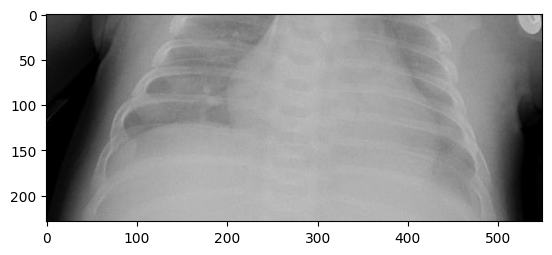

(229, 549, 3)
bacteria


In [8]:
def show_one_image_label(paths_list):
  idx = np.random.randint(0, len(paths_list))
  path = img_paths_all[idx]
  img = Image.open(path)
  print(np.array(img).shape)
  plt.imshow(img)
  plt.show()
  print(np.array(img).shape)
  label = path.split('/')[2]
  if label == "PNEUMONIA":
    label = path.split('_')[1]
  print(label)

show_one_image_label(img_paths_all)

In [9]:
def count_train_label(paths_list):

  counts = {'normal': 0, 'bacteria': 0, 'virus': 0}
  for path in paths_list:
    label = path.split('/')[2]
    if label == "NORMAL":
      counts['normal'] += 1
    elif path.split('_')[1] ==  "bacteria":
      counts['bacteria'] += 1
    else:
      counts['virus'] += 1
  cls = counts.keys()
  count = counts.values()
  return cls, count



<BarContainer object of 3 artists>

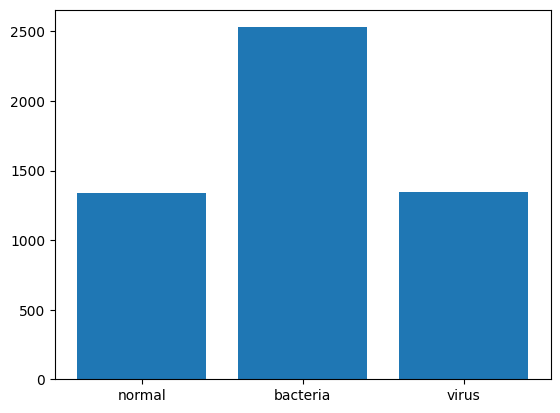

In [10]:
cls, count = count_train_label(img_paths_all)
plt.bar(cls, count)

Data set/ Data loader

In [11]:
import imgaug.augmenters as iaa
import imgaug as ia
from torchvision import models, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [12]:
transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()
transform


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [13]:
class PneumoniaDataset(torch.utils.data.Dataset):
  def __init__(self, paths, transform, aug):
    self.paths = paths
    self.transform = transform
    self.seq = iaa.Sequential(
        [
          iaa.GammaContrast(gamma=(0.9, 1)),
          iaa.Affine(
              scale=(0.8, 1),
              rotate=(-3, 3)
              )]
        )
    self.aug = aug
  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    path = self.paths[idx]
    img = Image.open(path).convert('RGB')
    img_np = np.array(img)
    if self.aug:
      img_np = self.seq.augment_image(img_np)
    img = Image.fromarray(img_np)
    img = self.transform(img)
    label = path.split('/')[2]
    if label == "PNEUMONIA":
      label = path.split('_')[1]
    cls_map = {'NORMAL': 0, 'bacteria': 1, 'virus': 2}
    label = cls_map[label]
    label = torch.tensor(label, dtype=torch.long)

    return img, label




In [14]:
train_ds = PneumoniaDataset(img_paths_train, transform, aug=True)
val_ds = PneumoniaDataset(img_paths_val, transform, aug=False)

In [15]:
# Number of samples
len(train_ds), len(val_ds)

(4172, 1044)

In [16]:
# Build DataLoaders
# BATCH_SIZE = 50
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

#### Build model

torch.Size([3, 224, 224]) 632 tensor(2)


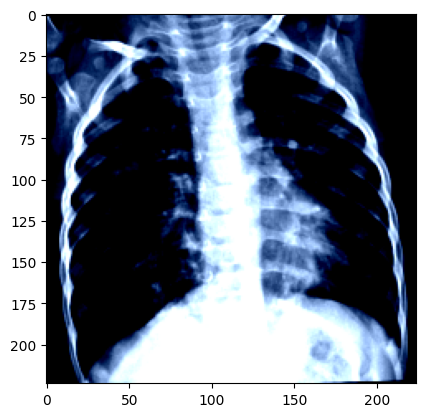

In [17]:
idx = np.random.randint(0, len(val_ds))
img, label = train_ds[idx]
print(img.shape, idx, label)
img = img.permute(1,2,0)
plt.imshow(img)
plt.show()

In [18]:
img, label

(tensor([[[-2.0837, -2.0007, -1.7696],
          [-2.0837, -2.0007, -1.7696],
          [-2.0837, -2.0007, -1.7696],
          ...,
          [-2.1179, -2.0357, -1.8044],
          [-2.1179, -2.0357, -1.8044],
          [-2.1179, -2.0357, -1.8044]],
 
         [[-0.5938, -0.4776, -0.2532],
          [-0.6109, -0.4951, -0.2707],
          [-1.0048, -0.8978, -0.6715],
          ...,
          [-2.1179, -2.0357, -1.8044],
          [-2.1179, -2.0357, -1.8044],
          [-2.1179, -2.0357, -1.8044]],
 
         [[ 0.2967,  0.4328,  0.6531],
          [ 0.4508,  0.5903,  0.8099],
          [-0.2342, -0.1099,  0.1128],
          ...,
          [-2.1179, -2.0357, -1.8044],
          [-2.1179, -2.0357, -1.8044],
          [-2.1179, -2.0357, -1.8044]],
 
         ...,
 
         [[-2.1179, -2.0357, -1.8044],
          [-2.1179, -2.0357, -1.8044],
          [-2.1179, -2.0357, -1.8044],
          ...,
          [-0.8335, -0.7227, -0.4973],
          [-0.9877, -0.8803, -0.6541],
          [-1.1589

#### Training

In [19]:
Freeze = True

In [20]:
model = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [21]:
num_feature = model.heads.head.in_features

if Freeze:
  for param in model.parameters():
    param.requires_grad = False
# 多層連階層
# model.fc = nn.Sequential(
#             nn.Dropout(0.4),
#             nn.Linear(num_feature , 128),
#             nn.Dropout(0.4),
#             nn.LeakyReLU(),
#             nn.Linear(128, NUM_CLASS))
# 單連接層
model.heads = nn.Linear(num_feature, NUM_CLASS)

In [22]:
inputs = torch.randn(1, 3, 224, 224).to(device)
model = model.to(device)
outputs = model(inputs)
outputs.shape

torch.Size([1, 3])

###Training

In [23]:
# 定義損失函數與激活函數
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                            lr=2*1e-4, weight_decay=0)

In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [25]:
from tqdm.auto import tqdm
EPOCHS = 100

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
erly_stop = 3
best_loss = np.inf
counter = 0
# best_model = model
# np.inf-無限大
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ', counter)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= erly_stop:
        print("Earlystop!")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 0.8961, train_acc: 0.586     val_loss: 0.7294, val_acc: 0.727  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 0.6802, train_acc: 0.732     val_loss: 0.6447, val_acc: 0.761  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 0.6213, train_acc: 0.743     val_loss: 0.6079, val_acc: 0.763  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 0.5843, train_acc: 0.760     val_loss: 0.5918, val_acc: 0.770  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.5672, train_acc: 0.764     val_loss: 0.5857, val_acc: 0.759  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.5461, train_acc: 0.776     val_loss: 0.5765, val_acc: 0.766  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.5399, train_acc: 0.773     val_loss: 0.5631, val_acc: 0.772  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.5276, train_acc: 0.773     val_loss: 0.5536, val_acc: 0.772  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.5173, train_acc: 0.784     val_loss: 0.5461, val_acc: 0.773  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 0.5208, train_acc: 0.777     val_loss: 0.5433, val_acc: 0.771  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 0.5104, train_acc: 0.787     val_loss: 0.5454, val_acc: 0.770  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 0.5034, train_acc: 0.787     val_loss: 0.5349, val_acc: 0.779  1


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 0.4914, train_acc: 0.787     val_loss: 0.5338, val_acc: 0.769  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 0.4938, train_acc: 0.796     val_loss: 0.5340, val_acc: 0.777  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 0.4932, train_acc: 0.788     val_loss: 0.5309, val_acc: 0.769  1


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 0.4790, train_acc: 0.797     val_loss: 0.5250, val_acc: 0.776  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 0.4793, train_acc: 0.802     val_loss: 0.5380, val_acc: 0.771  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.4742, train_acc: 0.802     val_loss: 0.5212, val_acc: 0.784  1


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0018     train_loss: 0.4730, train_acc: 0.799     val_loss: 0.5261, val_acc: 0.778  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0019     train_loss: 0.4731, train_acc: 0.797     val_loss: 0.5228, val_acc: 0.774  1


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0020     train_loss: 0.4659, train_acc: 0.799     val_loss: 0.5173, val_acc: 0.779  2


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0021     train_loss: 0.4669, train_acc: 0.799     val_loss: 0.5222, val_acc: 0.778  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0022     train_loss: 0.4684, train_acc: 0.806     val_loss: 0.5101, val_acc: 0.785  1


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0023     train_loss: 0.4690, train_acc: 0.799     val_loss: 0.5138, val_acc: 0.781  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0024     train_loss: 0.4557, train_acc: 0.807     val_loss: 0.5083, val_acc: 0.787  1


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0025     train_loss: 0.4594, train_acc: 0.801     val_loss: 0.5179, val_acc: 0.787  0


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0026     train_loss: 0.4559, train_acc: 0.808     val_loss: 0.5115, val_acc: 0.782  1


  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0027     train_loss: 0.4591, train_acc: 0.804     val_loss: 0.5123, val_acc: 0.784  2
Earlystop!


#### Make Kaggle Submission

In [49]:
model.load_state_dict(torch.load('last.pth'))
_ = model.eval().to(device)

In [50]:

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, paths, img_size=224):
        self.paths = paths
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img



In [51]:
test_ds = TestDataset(img_paths_test)
test_loader = torch.utils.data.DataLoader(test_ds, 64)

In [52]:
# Inference
y_pred = []
with torch.no_grad():
    for x in tqdm(test_loader):
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred.argmax(dim=1))

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]

In [53]:
df = pd.DataFrame()
df['Id'] = [f'{i:05d}.jpeg' for i in range(len(img_paths_test))]
df['Category'] = y_pred.astype(int)
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,00000.jpeg,0
1,00001.jpeg,1
2,00002.jpeg,1
3,00003.jpeg,2
4,00004.jpeg,1
...,...,...
619,00619.jpeg,2
620,00620.jpeg,1
621,00621.jpeg,0
622,00622.jpeg,1


In [54]:
from sklearn.metrics import classification_report, confusion_matrix

In [55]:
model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode
# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )
y_pred_probs = nn.Softmax(dim=1)(y_pred_logits) # convert logits to probability

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()

In [56]:
y_true.shape, y_pred_probs.shape, y_pred_cls.shape

((1044,), (1044, 3), (1044,))

In [57]:
acc = sum(y_true == y_pred_cls) / len(y_true)
acc

0.7844827586206896

In [58]:
print(classification_report(y_true, y_pred_cls))
print(confusion_matrix(y_true, y_pred_cls))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       274
           1       0.77      0.84      0.80       502
           2       0.64      0.55      0.59       268

    accuracy                           0.78      1044
   macro avg       0.79      0.77      0.77      1044
weighted avg       0.78      0.78      0.78      1044

[[248  15  11]
 [  8 424  70]
 [  6 115 147]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')